In [1]:
%load_ext autoreload
%autoreload 2
#pip install beautifulsoup4
#pip install plotly

In [2]:
import os
import pandas as pd
import gzip
import shutil
import requests
import numpy as np
import StormData
from bs4 import BeautifulSoup
import Dataloader as DL
%matplotlib inline

In [3]:
YEARS = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'] 
INIT_DATA = False
_decks = ['a', 'b']
#StormData.fetch_storm_data(_decks, INIT_DATA)
#for year in YEARS:
#    StormData.create_year_picklefile(year)

In [4]:
df_ens = pd.read_pickle("df_ens.pkl")
df_mean = pd.read_pickle("df_mean.pkl")
df_best = pd.read_pickle("df_best.pkl")
df_master_X = pd.read_pickle("df_master_X.pkl")
_dfm_diff = pd.read_pickle("_dfm_diff.pkl")

In [5]:
df_mean1 = df_mean
#df_mean1 = df_mean1[df_mean1['tech'] == 'AP20']
df_mean1['tau'].unique()

array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
        66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120.])

In [6]:
df_mean1['tau'] = pd.to_timedelta(df_mean1['tau'], unit='hours')
df_mean1['new_date'] = df_mean1.index + df_mean1['tau']
df_mean1

,basin,CY,techNum,tech,tau,lat,lon,vmax,MSLP,TY,new_date
date,,,,,,,,,,,
2008-05-31 00:00:00,AL,01,03,AEMN,0 days 00:00:00,17.0,-87.2,0,0,,2008-05-31 00:00:00
2008-05-31 00:00:00,AL,01,03,AEMN,0 days 06:00:00,17.8,-88.0,0,0,,2008-05-31 06:00:00
2008-05-31 00:00:00,AL,01,03,AEMN,0 days 12:00:00,18.3,-88.6,0,0,,2008-05-31 12:00:00
2008-05-31 00:00:00,AL,01,03,AEMN,0 days 18:00:00,18.7,-89.4,0,0,,2008-05-31 18:00:00
2008-05-31 00:00:00,AL,01,03,AEMN,1 days 00:00:00,18.9,-90.0,0,0,,2008-06-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11 12:00:00,AL,17,03,AEMN,0 days 06:00:00,34.7,-83.3,19,1001,XX,2022-11-11 18:00:00
2022-11-11 12:00:00,AL,17,03,AEMN,0 days 12:00:00,36.6,-81.2,18,1001,XX,2022-11-12 00:00:00
2022-11-11 12:00:00,AL,17,03,AEMN,0 days 18:00:00,39.3,-78.0,24,998,XX,2022-11-12 06:00:00


In [7]:
def create_best_dataframe(year, cy, df_best1, x):
    a = df_best1.loc[df_best1.index.year == year]
    df_best1 = a[a['CY'] == cy]
    df_best2 = df_best1.shift(-1)
    df = pd.merge(df_best1, df_best2, left_index=True, right_index=True)
    x = pd.concat([x, df])
    return x

In [8]:
def create_best_matrix(df_best1):
    x = pd.DataFrame()
    for year in df_best1.index.year.unique():
        for cy in df_best1['CY'].unique():
                x = create_best_dataframe(year, cy, df_best1, x)
    selected_columns = [col for col in x.columns if 'lat' in col or 'lon' in col or 'CY_x' in col]

    df_selected = x[selected_columns].dropna()
    return df_selected

In [9]:
df_best1 = df_best.drop_duplicates()
x = create_best_matrix(df_best1)

In [10]:
x

,CY_x,lat_x,lon_x,lat_y,lon_y
date,,,,,
2008-05-31 00:00:00,01,17.5,-87.5,17.8,-88.0
2008-05-31 06:00:00,01,17.8,-88.0,17.9,-88.2
2008-05-31 09:00:00,01,17.9,-88.2,18.0,-88.4
2008-05-31 12:00:00,01,18.0,-88.4,18.2,-88.8
2008-05-31 18:00:00,01,18.2,-88.8,18.3,-89.2
...,...,...,...,...,...
2022-11-10 18:00:00,17,29.0,-82.8,29.2,-83.0
2022-11-10 19:00:00,17,29.2,-83.0,30.1,-84.0
2022-11-11 00:00:00,17,30.1,-84.0,31.2,-84.6


In [11]:
# Merge the two DataFrames based on the new index column
merged_df = pd.merge(df_mean1, x, right_on=x.index, left_on=df_mean1['new_date'], how='inner')

# Remove the unnecessary columns
merged_df = merged_df.drop(['new_date'], axis=1)

In [12]:
merged_df

,key_0,basin,CY,techNum,tech,tau,lat,lon,vmax,MSLP,TY,CY_x,lat_x,lon_x,lat_y,lon_y
0,2008-05-31 00:00:00,AL,01,03,AEMN,0 days 00:00:00,17.0,-87.2,0,0,,01,17.5,-87.5,17.8,-88.0
1,2008-05-31 06:00:00,AL,01,03,AEMN,0 days 06:00:00,17.8,-88.0,0,0,,01,17.8,-88.0,17.9,-88.2
2,2008-05-31 06:00:00,AL,01,03,AEMN,0 days 00:00:00,18.0,-87.9,0,0,,01,17.8,-88.0,17.9,-88.2
3,2008-05-31 12:00:00,AL,01,03,AEMN,0 days 12:00:00,18.3,-88.6,0,0,,01,18.0,-88.4,18.2,-88.8
4,2008-05-31 12:00:00,AL,01,03,AEMN,0 days 06:00:00,18.3,-88.8,0,0,,01,18.0,-88.4,18.2,-88.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220451,2022-11-11 12:00:00,AL,17,03,AEMN,1 days 00:00:00,32.5,-84.6,23,997,XX,17,33.2,-84.6,35.4,-83.8
220452,2022-11-11 12:00:00,AL,17,03,AEMN,0 days 18:00:00,32.7,-84.5,21,998,XX,17,33.2,-84.6,35.4,-83.8
220453,2022-11-11 12:00:00,AL,17,03,AEMN,0 days 12:00:00,32.7,-84.4,20,999,XX,17,33.2,-84.6,35.4,-83.8
220454,2022-11-11 12:00:00,AL,17,03,AEMN,0 days 06:00:00,32.6,-84.5,19,999,XX,17,33.2,-84.6,35.4,-83.8


In [13]:
merged_df = merged_df[merged_df['CY'] == merged_df['CY_x']]

merged_df = merged_df.set_index('key_0')
merged_df = merged_df.rename_axis('date')

# Display the merged DataFrame
(merged_df)

,basin,CY,techNum,tech,tau,lat,lon,vmax,MSLP,TY,CY_x,lat_x,lon_x,lat_y,lon_y
date,,,,,,,,,,,,,,,
2008-05-31 00:00:00,AL,01,03,AEMN,0 days 00:00:00,17.0,-87.2,0,0,,01,17.5,-87.5,17.8,-88.0
2008-05-31 06:00:00,AL,01,03,AEMN,0 days 06:00:00,17.8,-88.0,0,0,,01,17.8,-88.0,17.9,-88.2
2008-05-31 06:00:00,AL,01,03,AEMN,0 days 00:00:00,18.0,-87.9,0,0,,01,17.8,-88.0,17.9,-88.2
2008-05-31 12:00:00,AL,01,03,AEMN,0 days 12:00:00,18.3,-88.6,0,0,,01,18.0,-88.4,18.2,-88.8
2008-05-31 12:00:00,AL,01,03,AEMN,0 days 06:00:00,18.3,-88.8,0,0,,01,18.0,-88.4,18.2,-88.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11 12:00:00,AL,17,03,AEMN,1 days 00:00:00,32.5,-84.6,23,997,XX,17,33.2,-84.6,35.4,-83.8
2022-11-11 12:00:00,AL,17,03,AEMN,0 days 18:00:00,32.7,-84.5,21,998,XX,17,33.2,-84.6,35.4,-83.8
2022-11-11 12:00:00,AL,17,03,AEMN,0 days 12:00:00,32.7,-84.4,20,999,XX,17,33.2,-84.6,35.4,-83.8


In [14]:
complete = merged_df[['tech', 'lat', 'lon', 'tau',
                      'lat_x', 'lon_x',
                      'lat_y', 'lon_y']]

In [15]:
from geopy.distance import geodesic
from haversine import haversine, Unit
import math

def calculate_angle(lat1, lon1, lat2, lon2, lat3, lon3):
    # Calculate the distances between the points
    d1 = haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS)
    d2 = haversine((lat2, lon2), (lat3, lon3), unit=Unit.KILOMETERS)
    d3 = haversine((lat1, lon1), (lat3, lon3), unit=Unit.KILOMETERS)
    
    # Check if any distance is zero
    if d1 == 0 or d2 == 0 or d3 == 0:
        return 0

    # Determine the orientation of the points using cross product
    cross_product = (lon2 - lon1) * (lat3 - lat1) - (lat2 - lat1) * (lon3 - lon1)
        
    # Calculate the angle between the lines using the Law of Cosines
    try:
        angle = math.acos((d1 ** 2 + d2 ** 2 - d3 ** 2) / (2 * d1 * d2))
    except ValueError:
        return 0
    
    # Adjust the sign of the angle based on the orientation of the points
    if cross_product > 0:
        angle = 2 * math.pi - angle
        
    angle_deg = math.degrees(angle)

    return angle_deg

In [16]:
def calculate_ate(lat1, lon1, lat2, lon2, lat3, lon3):
    angle = calculate_angle(lat1, lon1, lat2, lon2, lat3, lon3)
    return (haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS) * 
            math.cos(math.radians(angle)))

def calculate_cte(lat1, lon1, lat2, lon2, lat3, lon3):
    angle = calculate_angle(lat1, lon1, lat2, lon2, lat3, lon3)
    return (haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS) * 
            math.sin(math.radians(angle)))

def calculate_tte(lat1, lon1, lat2, lon2, lat3, lon3):
    return (haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS))

In [17]:
# Example coordinates
lat1, lon1 = 30.2, -77.5   # Point 1 coordinates
lat2, lon2 = 30, -77.2 # Point 2 coordinates
lat3, lon3 = 29.5, -77.5  # Point 3 coordinates

print(calculate_ate(lat1, lon1, lat2, lon2, lat3, lon3))
print(calculate_cte(lat1, lon1, lat2, lon2, lat3, lon3))

-6.390195136655028
35.86985831277012


In [18]:
# Apply calculate_ate function element-wise to create ATE column
complete['ATE'] = complete.apply(lambda row: calculate_ate(row['lat'], row['lon'], row['lat_x'], row['lon_x'], row['lat_y'], row['lon_y']), axis=1)

# Apply calculate_cte function element-wise to create CTE column
complete['CTE'] = complete.apply(lambda row: calculate_cte(row['lat'], row['lon'], row['lat_x'], row['lon_x'], row['lat_y'], row['lon_y']), axis=1)

# Apply calculate_cte function element-wise to create TTE column
complete['TTE'] = complete.apply(lambda row: calculate_tte(row['lat'], row['lon'], row['lat_x'], row['lon_x'], row['lat_y'], row['lon_y']), axis=1)

C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\2982547733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['ATE'] = complete.apply(lambda row: calculate_ate(row['lat'], row['lon'], row['lat_x'], row['lon_x'], row['lat_y'], row['lon_y']), axis=1)
C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\2982547733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['CTE'] = complete.apply(lambda row: calculate_cte(row['lat'], row['lon'], row['lat_x'], row['lon_x'], row['lat_y'], row['lon_y'])

In [19]:
complete['tau'] = complete['tau'].astype('timedelta64[h]').astype(int)

C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\2907735817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['tau'] = complete['tau'].astype('timedelta64[h]').astype(int)


In [20]:
complete['tau']

date
2008-05-31 00:00:00     0
2008-05-31 06:00:00     6
2008-05-31 06:00:00     0
2008-05-31 12:00:00    12
2008-05-31 12:00:00     6
                       ..
2022-11-11 12:00:00    24
2022-11-11 12:00:00    18
2022-11-11 12:00:00    12
2022-11-11 12:00:00     6
2022-11-11 12:00:00     0
Name: tau, Length: 99490, dtype: int32

In [21]:
# Extract the year from the datetime index and assign it to the 'Year' column
complete['Year'] = complete.index.year

# Retrieve the row with the minimum 'ATE' value for the specific condition
#min_ate_row = complete.loc[(complete['Year'] == 2017) & (complete['tau'] == 48)].loc[complete['ATE'].idxmin()]

# Remove the row from the 'complete' DataFrame
complete1 = complete #.drop(min_ate_row.index)

C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\2707052571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['Year'] = complete.index.year


In [22]:
import pandas as pd

# Convert the index column to datetime format
complete.index = pd.to_datetime(complete.index)

# Group the DataFrame by 'Year' and 'tau'
df_grouped = complete.groupby(['Year', 'tau'])

# Compute descriptive statistics on 'ATE' and 'CTE' columns within each group
statistics = df_grouped[['TTE', 'ATE', 'CTE']].describe()

statistics

TTE                                                             \
          count        mean         std        min         25%         50%   
Year tau                                                                     
2008 0    403.0   33.845781   31.033666   0.000000   14.700109   23.900688   
     6    405.0   60.756101   45.145488   0.000000   30.468025   52.127805   
     12   405.0   85.789762   56.452127   0.000000   45.516719   74.310064   
     18   403.0  109.176674   68.800467   0.000000   58.388142   92.952634   
     24   395.0  131.326975   80.942732   8.145516   71.035512  114.857047   
...         ...         ...         ...        ...         ...         ...   
2022 96   203.0  266.587748  160.220097  11.119508  133.952860  238.449483   
     102  196.0  287.609487  170.390972   0.000000  148.163627  258.965565   
     108  191.0  308.178308  182.336581  20.207297  149.209803  276.497832   
     114  185.0  328.477856  190.265858  27.030389  156.099350  314.158665   
     120  178.0  345.280160  200.708013  23.381285  158.590020  351.508712   

                                    ATE              ...              \
                 75%         max  count        mean  ...         75%   
Year tau                                             ...               
2008 0     43.015418  280.645806  403.0    3.623444  ...   15.477830   
     6     77.836556  355.674994  405.0    4.213584  ...   28.932278   
     12   106.483751  334.868507  405.0    8.760111  ...   46.671580   
     18   149.025369  368.064974  403.0   16.432972  ...   67.254374   
     24   180.383341  433.775619  395.0   21.651612  ...   81.295080   
...              ...         ...    ...         ...  ...         ...   
2022 96   376.634979  779.644647  203.0  -87.544926  ...   93.963844   
     102  423.831346  794.701657  196.0  -94.520186  ...   83.438764   
     108  452.702104  778.933246  191.0 -100.193840  ...   90.525820   
     114  466.890826  766.470439  185.0 -102.149943  ...  108.970991   
     120  468.762534  817.701969  178.0  -97.234682  ...   89.224729   

                        CTE                                                 \
                 max  count       mean         std         min         25%   
Year tau                                                                     
2008 0    133.108639  403.0 -10.501115   34.541734 -146.284914  -22.907552   
     6    203.886632  405.0 -23.642978   51.882109 -231.772180  -50.526022   
     12   243.764142  405.0 -35.683932   66.154884 -282.931508  -72.219551   
     18   342.938680  403.0 -45.549303   80.372248 -354.162208  -91.632264   
     24   408.592151  395.0 -51.692392   92.815771 -430.965092 -105.959193   
...              ...    ...        ...         ...         ...         ...   
2022 96   540.965766  203.0 -33.829584  205.235379 -574.269087 -137.776839   
     102  591.780655  196.0 -41.481197  221.138565 -574.836078 -145.695727   
     108  643.454885  191.0 -42.723560  238.281527 -683.370646 -157.944919   
     114  638.023498  185.0 -49.580961  254.988183 -755.346175 -151.150699   
     120  695.364797  178.0 -61.707207  268.961627 -803.218742 -179.833005   

                                            
                50%        75%         max  
Year tau                                    
2008 0    -6.087496   6.700739  205.953734  
     6   -17.508847   5.225384  301.642643  
     12  -31.869171   0.060377  301.175660  
     18  -39.173269   0.295426  300.714139  
     24  -52.724942   4.017735  264.380137  
...             ...        ...         ...  
2022 96  -12.853085  83.342463  703.950846  
     102 -25.484467  73.181793  790.907193  
     108 -18.457879  73.018145  765.339327  
     114 -41.488931  78.493176  750.873193  
     120 -33.768049  66.274420  792.259362  

[315 rows x 24 columns]

C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\583883188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year'] % 100
C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\583883188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))
C:\Users\nagra\anaconda3\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifyin

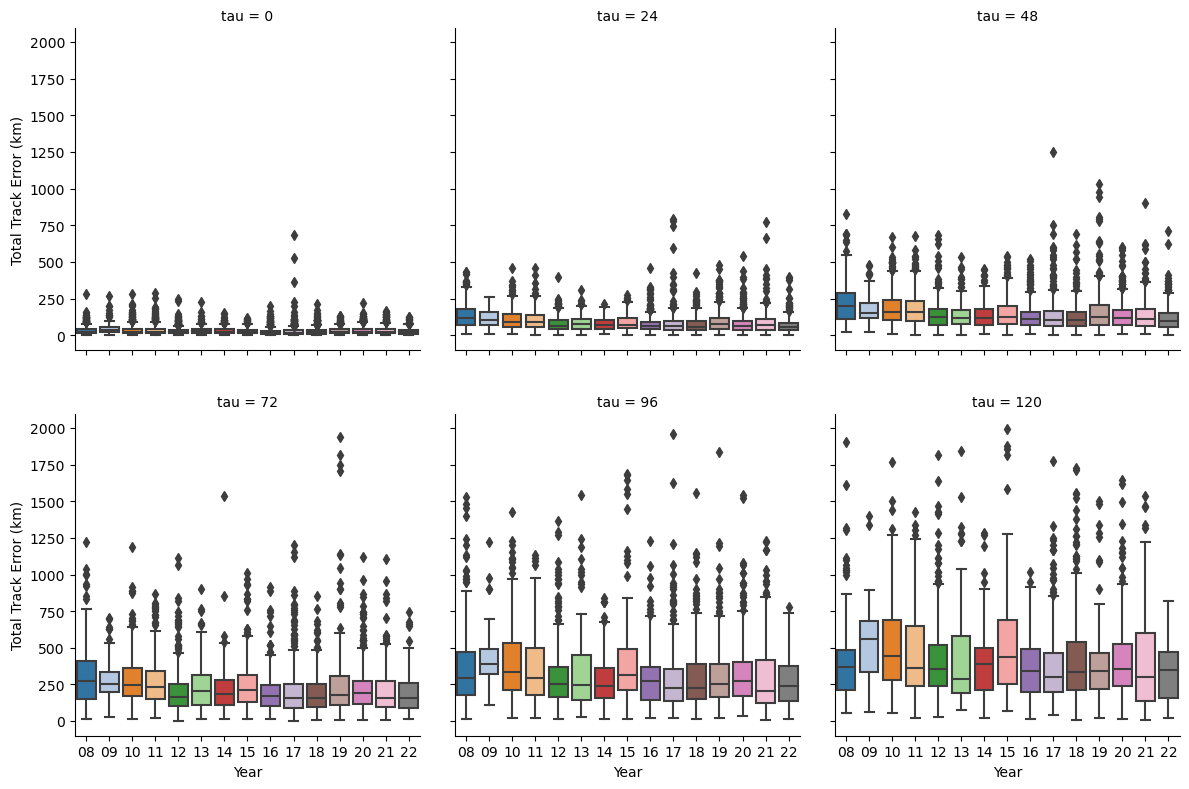

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'complete1' DataFrame with 'Year', 'TTE', and 'tau' columns

# Extract the last two digits of the 'Year' column and create a new column 'Year_last_two_digits'
complete1['Year_last_two_digits'] = complete1['Year'] % 100
complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))

# Filter rows where 'tau' is divisible by 24
complete1_filtered = complete1[complete1['tau'] % 24 == 0]

# Filter 'TTE' values that are greater than 3000
complete1_filtered = complete1_filtered[complete1_filtered['TTE'] <= 2000]
complete1_filtered = complete1_filtered[complete1_filtered['TTE'] >= -2000]

# Create a FacetGrid with subplots based on the 'tau' column, with individual y-axis scales per row
grid = sns.FacetGrid(complete1_filtered, col='tau', col_wrap=3, height=4, sharey='row')
custom_palette = sns.color_palette('tab20', 15)

# Create a box plot in each subplot using seaborn, with different colors based on the 'Year_last_two_digits' column
grid.map(sns.boxplot, 'Year_last_two_digits', 'TTE', palette=custom_palette)

# Set labels and title for each subplot
grid.set_axis_labels('Year', 'Total Track Error (km)')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.1)  # Adjust the hspace and wspace as needed

# Display the plot
plt.show()

C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\2022310205.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year'] % 100
C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\2022310205.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))
C:\Users\nagra\anaconda3\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use 

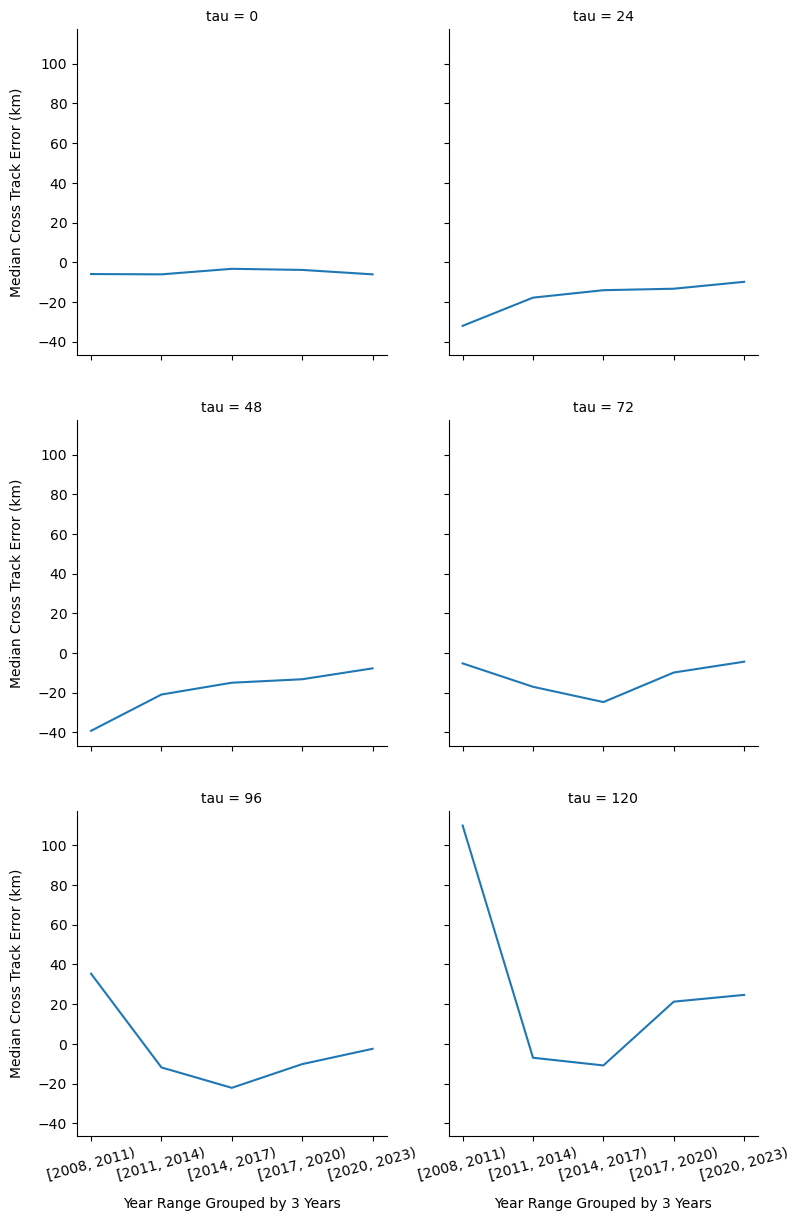

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'complete1' DataFrame with 'Year', 'TTE', and 'tau' columns

# Extract the last two digits of the 'Year' column and create a new column 'Year_last_two_digits'
complete1['Year_last_two_digits'] = complete1['Year'] % 100
complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))

complete1_filtered = complete1[(complete1['tau'] % 24 == 0)].copy()  # Create a copy of the DataFrame

# Group the data by every three years and calculate the median for each group
complete1_filtered['Year_grouped'] = pd.cut(complete1_filtered['Year'], bins=range(2008, 2025, 3), right=False)
medians = complete1_filtered.groupby(['Year_grouped', 'tau'])['CTE'].median().reset_index()

# Convert 'Year_grouped' to a string data type
medians['Year_grouped'] = medians['Year_grouped'].astype(str)

# Create a FacetGrid with subplots based on the 'tau' column, with individual y-axis scales per row
grid = sns.FacetGrid(medians, col='tau', col_wrap=2, height=4, sharey='row')

# Calculate medians for each 'tau' value and plot them as line graphs in each subplot
grid.map(sns.lineplot, 'Year_grouped', 'CTE', ci=None)

# Set labels and title for each subplot
grid.set_axis_labels('Year Range Grouped by 3 Years', 'Median Cross Track Error (km)', labelpad=10)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust the hspace and wspace as needed

# Change the x-axis tick label font size
grid.set(xticks=range(len(medians['Year_grouped'].unique())))
grid.set_xticklabels(labels=medians['Year_grouped'].unique(), rotation=15, fontsize=10)  # Adjust the fontsize as needed

# Display the plot
plt.show()


C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\1819431769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year'] % 100
C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\1819431769.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))


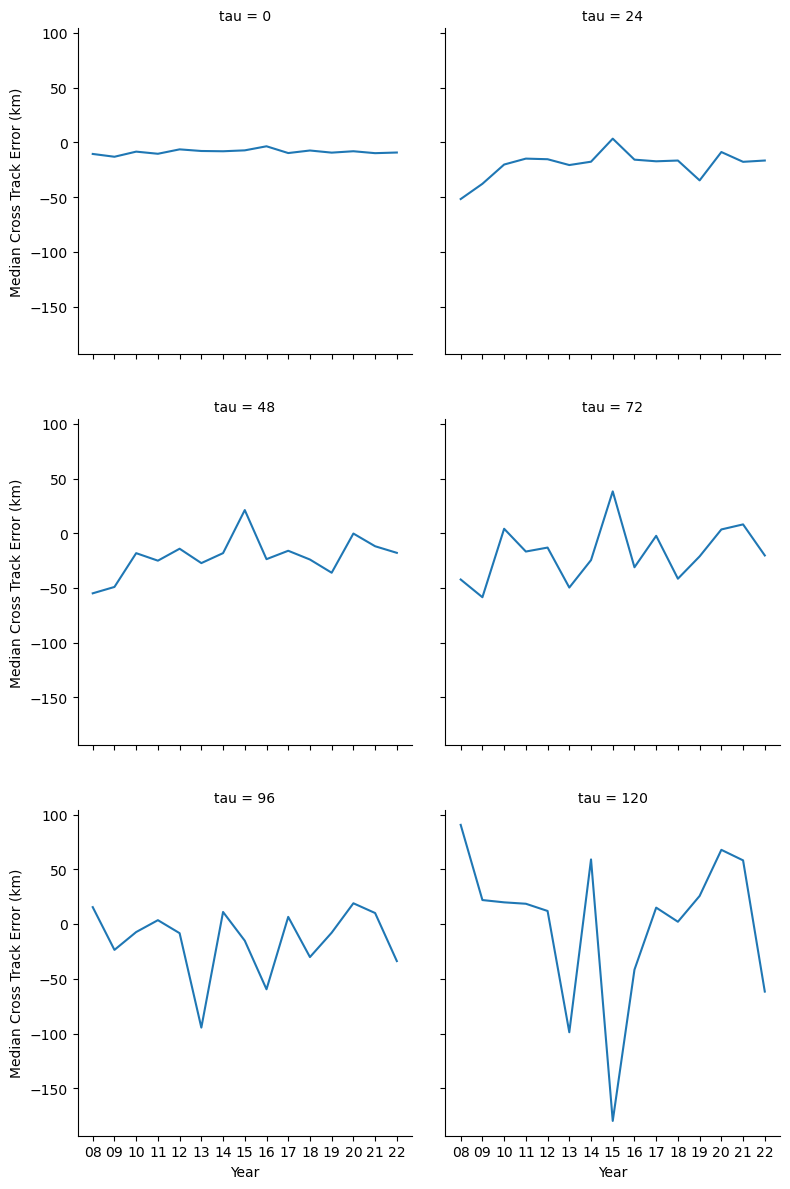

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'complete1' DataFrame with 'Year', 'TTE', and 'tau' columns

# Extract the last two digits of the 'Year' column and create a new column 'Year_last_two_digits'
complete1['Year_last_two_digits'] = complete1['Year'] % 100
complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))

complete1_filtered = complete1[(complete1['tau'] % 24 == 0)].copy()  # Create a copy of the DataFrame

# Create a FacetGrid with subplots based on the 'tau' column, with individual y-axis scales per row
grid = sns.FacetGrid(complete1_filtered, col='tau', col_wrap=2, height=4, sharey='row')

# Calculate medians for each 'tau' value and plot them as line graphs in each subplot
grid.map(sns.lineplot, 'Year_last_two_digits', 'CTE', errorbar=None)

# Set labels and title for each subplot
grid.set_axis_labels('Year', 'Median Cross Track Error (km)')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.1)  # Adjust the hspace and wspace as needed

# Display the plot
plt.show()


C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\3053769466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year'] % 100
C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\3053769466.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))
C:\Users\nagra\anaconda3\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use 

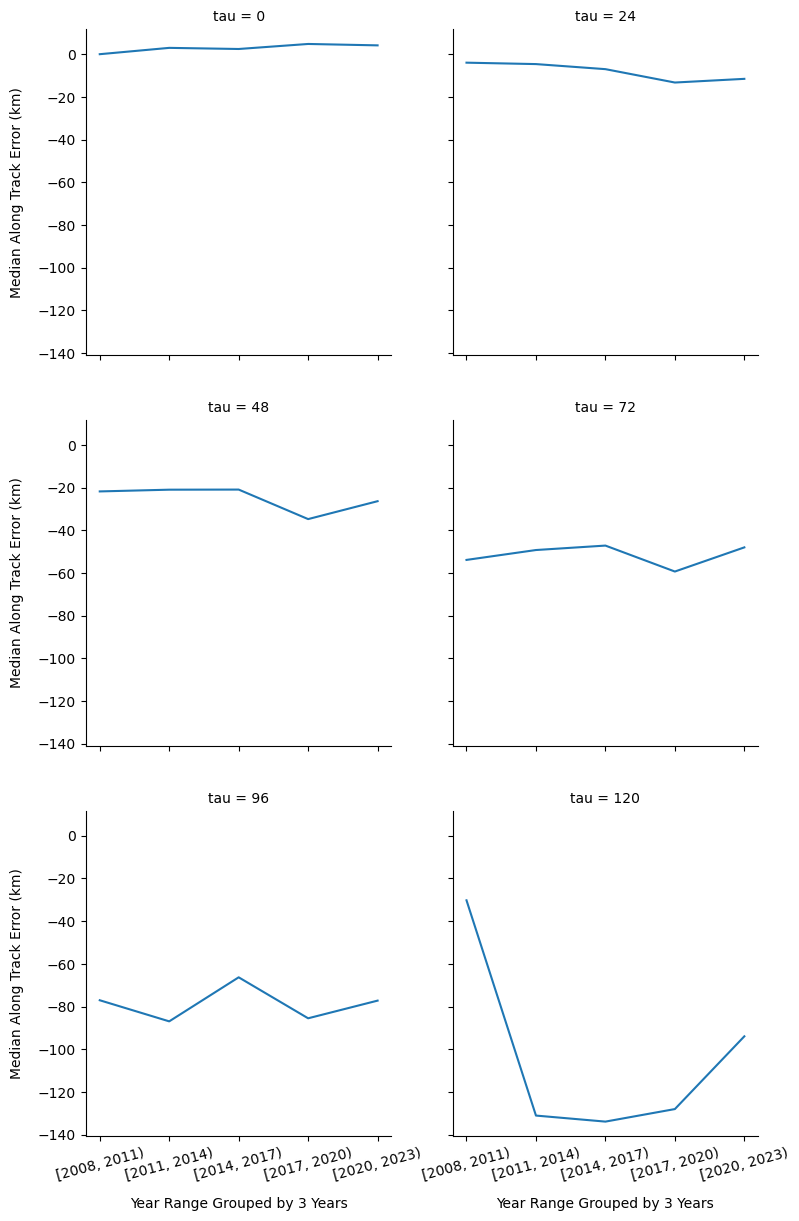

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'complete1' DataFrame with 'Year', 'TTE', and 'tau' columns

# Extract the last two digits of the 'Year' column and create a new column 'Year_last_two_digits'
complete1['Year_last_two_digits'] = complete1['Year'] % 100
complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))

complete1_filtered = complete1[(complete1['tau'] % 24 == 0)].copy()  # Create a copy of the DataFrame

# Group the data by every three years and calculate the median for each group
complete1_filtered['Year_grouped'] = pd.cut(complete1_filtered['Year'], bins=range(2008, 2025, 3), right=False)
medians = complete1_filtered.groupby(['Year_grouped', 'tau'])['ATE'].median().reset_index()

# Convert 'Year_grouped' to a string data type
medians['Year_grouped'] = medians['Year_grouped'].astype(str)

# Create a FacetGrid with subplots based on the 'tau' column, with individual y-axis scales per row
grid = sns.FacetGrid(medians, col='tau', col_wrap=2, height=4, sharey='row')

# Calculate medians for each 'tau' value and plot them as line graphs in each subplot
grid.map(sns.lineplot, 'Year_grouped', 'ATE', ci=None)

# Set labels and title for each subplot
grid.set_axis_labels('Year Range Grouped by 3 Years', 'Median Along Track Error (km)', labelpad=10)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust the hspace and wspace as needed

# Change the x-axis tick label font size
grid.set(xticks=range(len(medians['Year_grouped'].unique())))
grid.set_xticklabels(labels=medians['Year_grouped'].unique(), rotation=15, fontsize=10)  # Adjust the fontsize as needed

# Display the plot
plt.show()


C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\1226486021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year'] % 100
C:\Users\nagra\AppData\Local\Temp\ipykernel_10828\1226486021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))


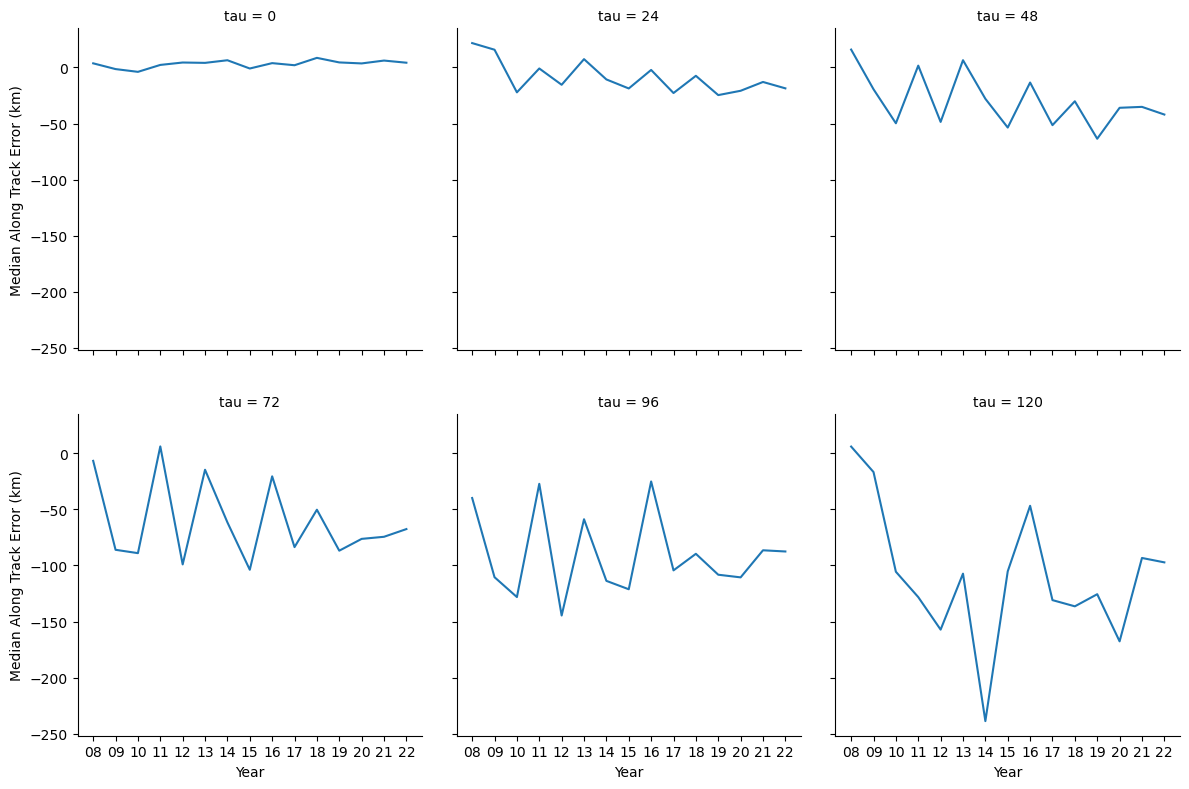

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the 'complete1' DataFrame with 'Year', 'TTE', and 'tau' columns

# Extract the last two digits of the 'Year' column and create a new column 'Year_last_two_digits'
complete1['Year_last_two_digits'] = complete1['Year'] % 100
complete1['Year_last_two_digits'] = complete1['Year_last_two_digits'].apply(lambda x: str(x).zfill(2))

complete1_filtered = complete1[(complete1['tau'] % 24 == 0)].copy()  # Create a copy of the DataFrame

# Create a FacetGrid with subplots based on the 'tau' column, with individual y-axis scales per row
grid = sns.FacetGrid(complete1_filtered, col='tau', col_wrap=3, height=4, sharey='row')

# Calculate medians for each 'tau' value and plot them as line graphs in each subplot
grid.map(sns.lineplot, 'Year_last_two_digits', 'ATE', errorbar=None)

# Set labels and title for each subplot
grid.set_axis_labels('Year', 'Median Along Track Error (km)')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.1)  # Adjust the hspace and wspace as needed

# Display the plot
plt.show()


In [28]:
import pandas as pd

# Calculate the mean
print("ATE Mean:", complete['ATE'].mean())

# Calculate the median
print("ATE Median:", complete['ATE'].median())

# Calculate the standard deviation
print("ATE Standard Deviation:", complete['ATE'].std())

# You can also perform hypothesis tests
# For example: t-test against a specific value
from scipy.stats import ttest_1samp

# Perform t-test
t_statistic, p_value = ttest_1samp(complete['ATE'], 0)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


ATE Mean: -41.72522905167401
ATE Median: -14.734283560721561
ATE Standard Deviation: 201.96255019091888
T-Statistic: -65.16548005783788
P-Value: 0.0


In [29]:
import pandas as pd

# Calculate the mean
print("CTE Mean:", complete['CTE'].mean())

# Calculate the median
print("CTE Median:", complete['CTE'].median())

# Calculate the standard deviation
print("CTE Standard Deviation:", complete['CTE'].std())

# You can also perform hypothesis tests
# For example: t-test against a specific value
from scipy.stats import ttest_1samp

# Perform t-test
t_statistic, p_value = ttest_1samp(complete['CTE'], 0)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


CTE Mean: -14.264762344112594
CTE Median: -10.638303998753019
CTE Standard Deviation: 159.96496364795576
T-Statistic: -28.127386723233958
P-Value: 2.1749063470238722e-173


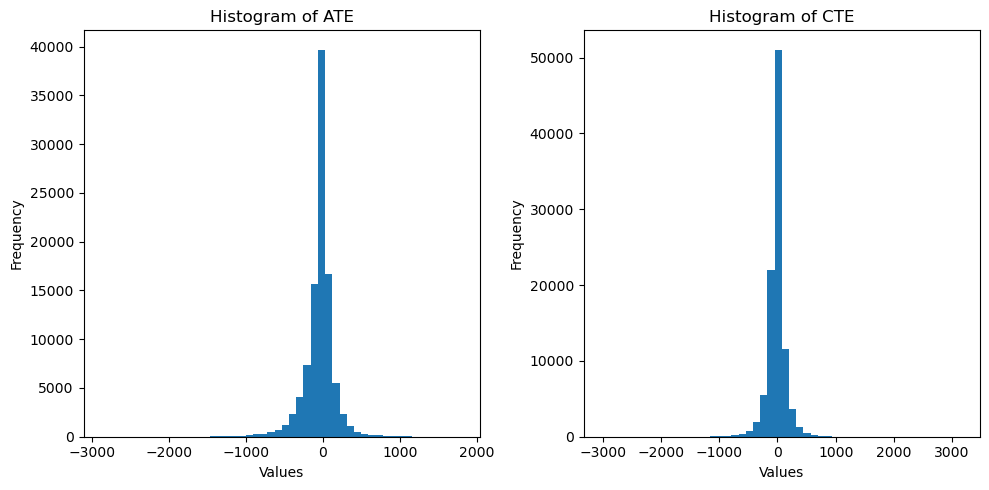

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for column1
ax1.hist(complete['ATE'], bins=50)  # Adjust the number of bins as needed
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of ATE')

# Plot histogram for column2
ax2.hist(complete['CTE'], bins=50)  # Adjust the number of bins as needed
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of CTE')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

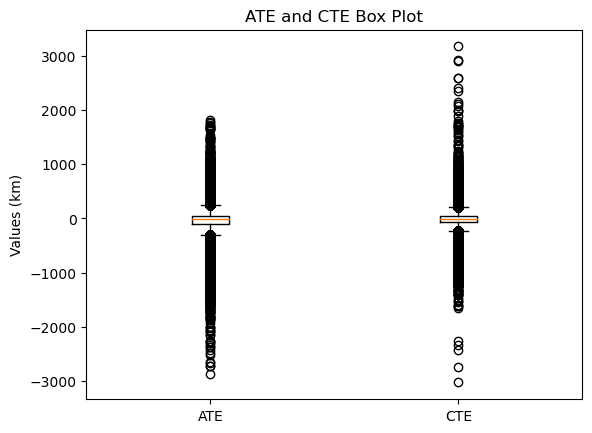

In [31]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Create the side-by-side box plots
box_plot_data = [complete['ATE'], complete['CTE']]
ax.boxplot(box_plot_data)

# Set the x-axis tick labels
ax.set_xticklabels(['ATE', 'CTE'])

# Set the y-axis label
ax.set_ylabel('Values (km)')

# Set the title of the plot
ax.set_title('ATE and CTE Box Plot')

# Show the plot
plt.show()

In [32]:
import pandas as pd
from scipy.stats import shapiro

column_data = complete['CTE']

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(column_data)

# Set the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
print(f"p-value: {p_value}")
if p_value < alpha:
    print("The column is not normally distributed.")
else:
    print("The column is normally distributed.")

p-value: 0.0
The column is not normally distributed.


C:\Users\nagra\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [33]:
import pandas as pd
from scipy import stats

population_mean = 0  # ideally there would be no error

# Extract the data from the column
data = complete['CTE']

# Perform the t-test
t_statistic, p_value = stats.ttest_1samp(data, population_mean)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: -28.127386723233958
P-value: 2.1749063470238722e-173


In [34]:
from scipy.stats import kstest

data = complete['ATE']
statistic, p_value = kstest(data, 'norm')
print("Kolmogorov-Smirnov Test - p-value:", p_value)

Kolmogorov-Smirnov Test - p-value: 0.0


In [35]:
from scipy.stats import pearsonr

data1 = complete['ATE']
data2 = complete['CTE']
correlation, p_value = pearsonr(data1, data2)
print("Pearson's Correlation Coefficient - p-value:", p_value)

Pearson's Correlation Coefficient - p-value: 3.8135356127097117e-147
